# Introduction

In this project, we will examine a dataset of hotel bookings for two hotels, a resort hotel and a city hotel, in Portugal from 2015 to 2017. The goals of the project are to understand the patterns of bookings at the hotels, explore how cancellations may be related to different variables such as time or number of guests, and develop a model to help predict which bookings are likely to be canceled so hotels can better manage their room inventory.

Sources:

Dataset was obtained from Kaggle [here](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand).

Original article by Antonio et al. 2019 [here](https://www.sciencedirect.com/science/article/pii/S2352340918315191).


# Import  Python modules and dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.formula.api import logit
plt.rcParams["figure.figsize"] = (9, 6)

In [5]:
hotels = pd.read_csv('hotels.csv')
hotels.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/2015


# Data Cleansing

In [6]:
hotels.shape

(119390, 32)

In [7]:
hotels.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [8]:
hotels.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [9]:
#Correct columns' data types
hotels = hotels.astype({'is_canceled':'bool', 'is_repeated_guest':'bool','arrival_date_year':'str', 'arrival_date_day_of_month':'str'})
hotels.dtypes

hotel                              object
is_canceled                          bool
lead_time                           int64
arrival_date_year                  object
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month          object
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                    bool
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [49]:
#Create new columns needed for analysis
hotels['arrival_date'] = hotels.arrival_date_year + ' ' + hotels.arrival_date_month + ' ' + hotels.arrival_date_day_of_month
hotels.arrival_date = pd.to_datetime(hotels.arrival_date)
hotels['total_rate_estimated'] = (hotels['stays_in_weekend_nights'] + hotels['stays_in_week_nights'])*hotels['adr']
hotels['pct_previous_bookings_canceled'] = 100.0* hotels.previous_cancellations / (hotels.previous_cancellations + hotels.previous_bookings_not_canceled)
hotels['is_canceled_int'] = hotels.is_canceled.astype(int)
hotels['stays_total_nights'] = hotels.stays_in_weekend_nights + hotels.stays_in_week_nights
hotels['total_guests'] = hotels.adults + hotels.children + hotels.babies

In [50]:
hotels.dtypes

hotel                                     object
is_canceled                                 bool
lead_time                                  int64
arrival_date_year                         object
arrival_date_month                        object
arrival_date_week_number                   int64
arrival_date_day_of_month                 object
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                 float64
babies                                     int64
meal                                      object
country                                   object
market_segment                            object
distribution_channel                      object
is_repeated_guest                           bool
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type  

In [51]:
#Check for duplicate rows and drop them
hotels.duplicated().sum()
hotels = hotels.drop_duplicates()

In [52]:
resort = hotels[hotels.hotel == 'Resort Hotel']
city = hotels[hotels.hotel == 'City Hotel']

# Executive Summary

Analysis of hotel data for a city hotel and resort hotel from July 2015 to August 2017 shows an increase in city hotel bookings, while resort hotel bookings have remained nearly constant. Meanwhile, cancellation rates at both hotels have been increasing over time, taking into account some local dips that appear to be seasonally related. If this continues, we may have difficulty filling rooms and maximizing profit at the resort hotel.

Recommendations to improve performance at the resort hotel:
1. Increase marketing and consider discounting rooms during the summer months, when there are higher rates of cancellation and we can be more comfortable overbooking knowing that guests are likely to cancel.
2. Single travelers and smaller parties of 2 are less prevalent at the resort hotel. We should take measures to market toward these demographics by either discounting single bed rooms or investing in activities that single travelers might be interested in, such as parties and group sports.
3. Market more toward travelers from the UK and France, which have high booking numbers and low cancellation rate.s
4. Entice driving guests to stay by discounting parking or increasing parking infrastructure. Guests who park are exceedingly unlikely to cancel in our model.
5. Guests at the resort hotel are more likely to stay for longer periods. We may be able to attract more guests like this by offering discounts for longer stays.


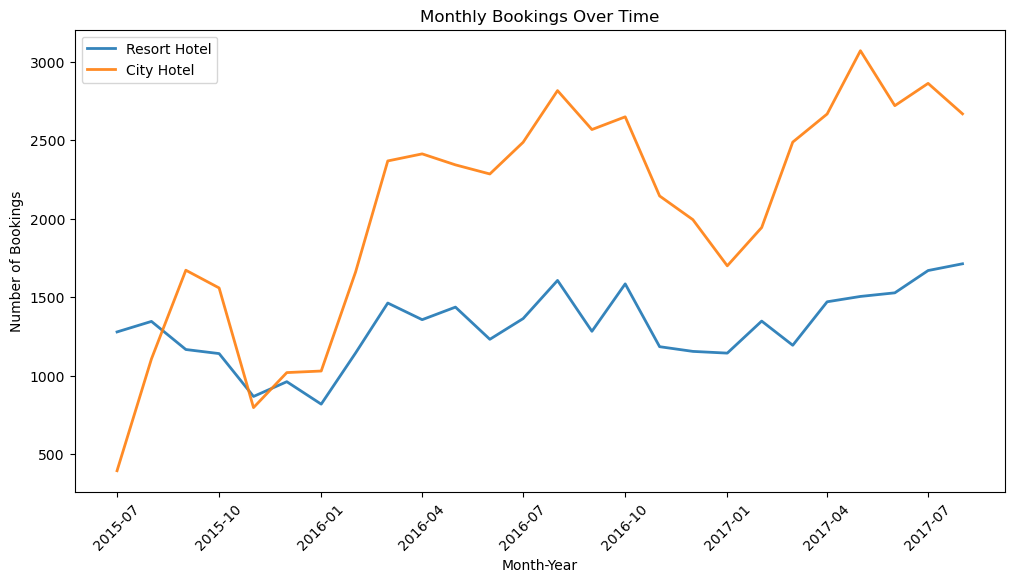

In [53]:
hotels['month_year'] = hotels['arrival_date'].dt.to_period('M').dt.to_timestamp()

monthly_booking_counts = hotels.groupby(['hotel', 'month_year']).size().reset_index(name='booking_count')

monthly_booking_counts_pivot = monthly_booking_counts.pivot(index='month_year', columns='hotel', values='booking_count').fillna(0)

plt.figure(figsize=(12, 6))
ax=plt.gca()
ax.plot(monthly_booking_counts_pivot.index, monthly_booking_counts_pivot['Resort Hotel'], marker='', linewidth=2, alpha=0.9, label='Resort Hotel')
ax.plot(monthly_booking_counts_pivot.index, monthly_booking_counts_pivot['City Hotel'], marker='', linewidth=2, alpha=0.9, label='City Hotel')

    
plt.title("Monthly Bookings Over Time")
plt.xlabel("Month-Year")
plt.ylabel("Number of Bookings")
plt.legend()
plt.xticks(rotation=45)

plt.show()

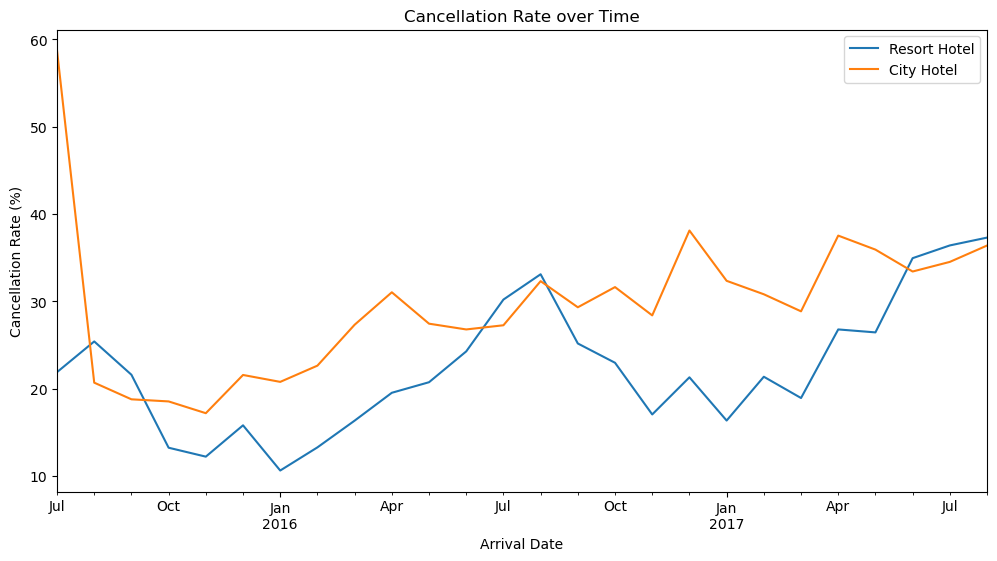

In [54]:
resort_monthly_cancel_count = resort.groupby(pd.Grouper(key='arrival_date', freq='M')).is_canceled.sum()
resort_monthly_total_count = resort.groupby(pd.Grouper(key='arrival_date', freq='M')).size()
resort_monthly_cancel_rate = resort_monthly_cancel_count * 100 / resort_monthly_total_count 
city_monthly_cancel_count = city.groupby(pd.Grouper(key='arrival_date', freq='M')).is_canceled.sum()
city_monthly_total_count = city.groupby(pd.Grouper(key='arrival_date', freq='M')).size()
city_monthly_cancel_rate = city_monthly_cancel_count * 100 / city_monthly_total_count 
plt.figure(figsize=(12, 6))
resort_monthly_cancel_rate.plot(kind='line', label='Resort Hotel')
city_monthly_cancel_rate.plot(kind='line', label='City Hotel')
plt.legend()
plt.ylabel('Cancellation Rate (%)')
plt.xlabel('Arrival Date')
plt.title('Cancellation Rate over Time')
plt.show()


# Exploratory Data Analysis


Let's first explore the data a little bit to learn more about our dataset and its general properties, as well as basic facts like number of bookings vs cancellations.

## Total Bookings

Our city hotel has significantly more bookings than the resort hotel. While we don't know the total capacity of the hotels, this could be an indicator that the resort hotel may be underperforming, or it could simply be a natural consequence of their locations.

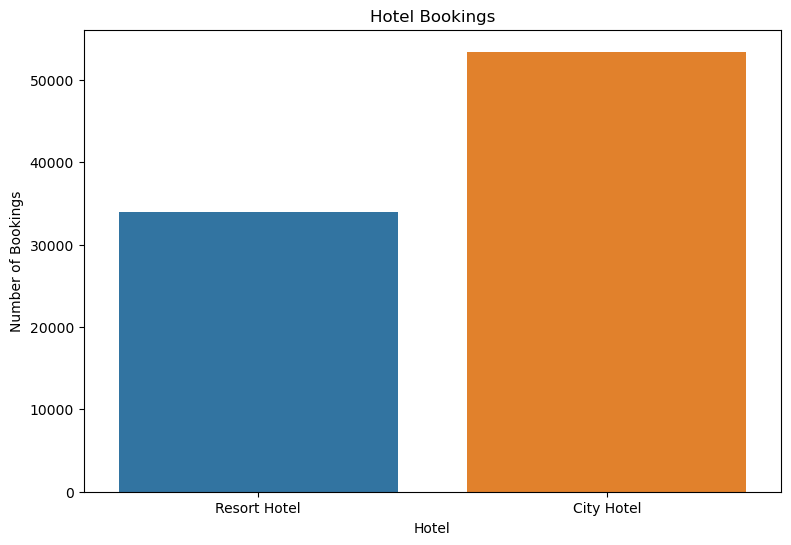

In [55]:
ax = sns.countplot(data=hotels, x='hotel')
plt.title('Hotel Bookings')
plt.xlabel('Hotel')
plt.ylabel('Number of Bookings')
plt.show()



## Bookings by Month

Bookings for the city hotel have been overall trending up, with small dips around Nov 2015 and Jan 2017. There appears to be some slight seasonality with troughs in late fall/early winter and peaks in late spring/summer, but more data is needed to confirm this. The resort hotel has been more stable, hovering between 1000 to 1500 bookings per month for the entire period analyzed. 

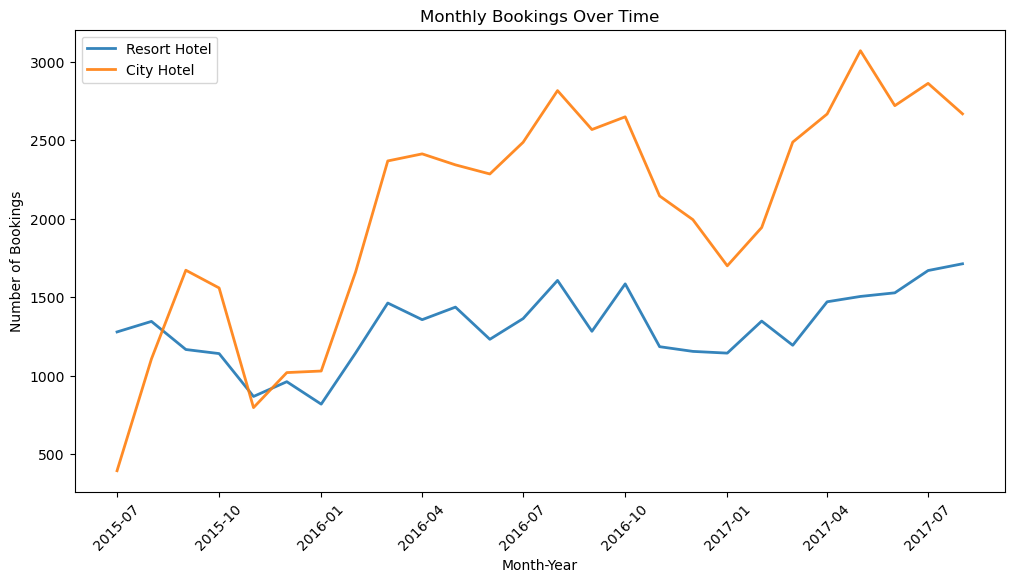

In [56]:
hotels['month_year'] = hotels['arrival_date'].dt.to_period('M').dt.to_timestamp()

monthly_booking_counts = hotels.groupby(['hotel', 'month_year']).size().reset_index(name='booking_count')

monthly_booking_counts_pivot = monthly_booking_counts.pivot(index='month_year', columns='hotel', values='booking_count').fillna(0)

plt.figure(figsize=(12, 6))
ax=plt.gca()
ax.plot(monthly_booking_counts_pivot.index, monthly_booking_counts_pivot['Resort Hotel'], marker='', linewidth=2, alpha=0.9, label='Resort Hotel')
ax.plot(monthly_booking_counts_pivot.index, monthly_booking_counts_pivot['City Hotel'], marker='', linewidth=2, alpha=0.9, label='City Hotel')

    
plt.title("Monthly Bookings Over Time")
plt.xlabel("Month-Year")
plt.ylabel("Number of Bookings")
plt.legend()
plt.xticks(rotation=45)

plt.show()

## Stay Length

Most guests tend to stay between 1 to 4 nights for both hotels, with a peak at 2-3 nights for both hotels. Resort hotels see more bookings for longer durations (6 or more nights), which could be due to vacationers and the nature of the resort hotel. City hotels have a more pronounced peak between 2 - 3 nights, suggesting they have a higher proportion of short-term visitors. 

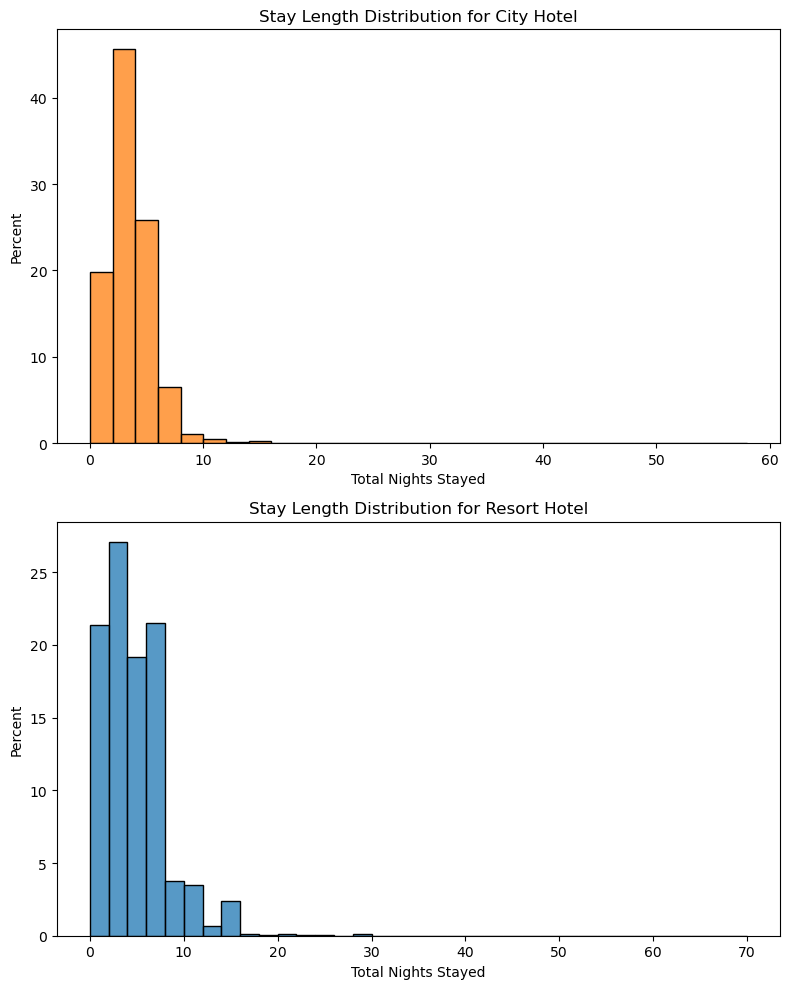

In [57]:
ig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

hotel_names = ['City Hotel', 'Resort Hotel']

for i, hotel in enumerate(hotel_names):
    ax = axes[i]
    data = hotels[hotels['hotel'] == hotel]
    color = 'tab:orange' if hotel == 'City Hotel' else 'tab:blue'
    sns.histplot(data=data, x='stays_total_nights', binwidth=2, ax=ax, stat='percent', color=color)
    ax.set_title(f'Stay Length Distribution for {hotel}')
    ax.set_xlabel('Total Nights Stayed')
    

plt.tight_layout()

plt.show()

## Guests per Booking

Both city and resort hotels have a similar number of total guests per booking, with the distribution peaking at 2 guests. Interestingly, resort hotels have a higher proportion of bookings with 4 guests, which may represent families who vacation at the resort.

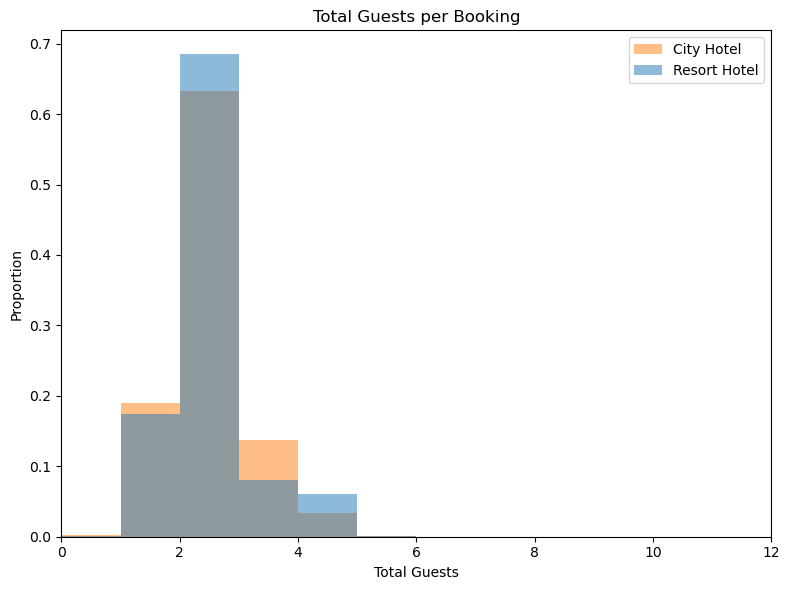

In [58]:
fig, ax = plt.subplots(figsize=(8, 6))
for hotel in hotel_names:
    data = hotels[hotels['hotel'] == hotel]
    color = 'tab:orange' if hotel == 'City Hotel' else 'tab:blue'
    
    ax.hist(data['total_guests'], bins=range(0, 10), alpha=0.5, label=f'{hotel}', color=color, density=True)
    

ax.set_xlim(0, 12)
ax.set_xlabel('Total Guests')
ax.set_ylabel('Proportion')
ax.set_title('Total Guests per Booking')
ax.legend()

plt.tight_layout()
plt.show()



## Booking Lead Time

At both hotels, the majority of bookings made less than two months out. The resort hotel has a significantly greater percentage of bookings made within a week from check-in date.

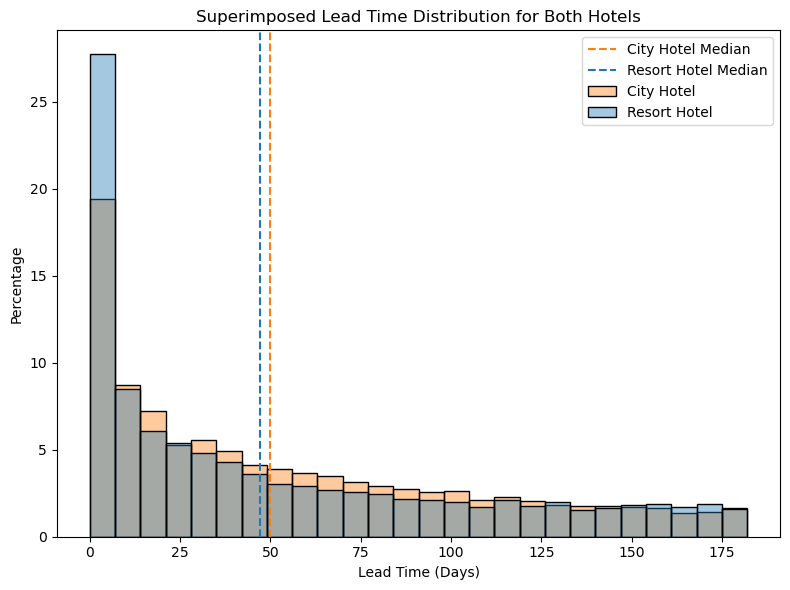

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))

for hotel in hotel_names:
    data = hotels[hotels['hotel'] == hotel]
    color = 'tab:orange' if hotel == 'City Hotel' else 'tab:blue'
    sns.histplot(data=data, x='lead_time', binwidth=7, binrange=(0,182), alpha=0.4, stat='percent', color=color, ax=ax, label=hotel)
    median_value = data['lead_time'].median()
    ax.axvline(median_value, color=color, linestyle='--', label=f'{hotel} Median')

ax.set_xlabel('Lead Time (Days)')
ax.set_ylabel('Percentage')
ax.set_title('Superimposed Lead Time Distribution for Both Hotels')

ax.legend()

plt.tight_layout()
plt.show()


# Examining cancellations


City hotels have a higher cancellation rate. As a result, we may be able to oversell hotel rooms at the city hotel more comfortably knowing that there's a higher likelihood of the reservation being canceled.

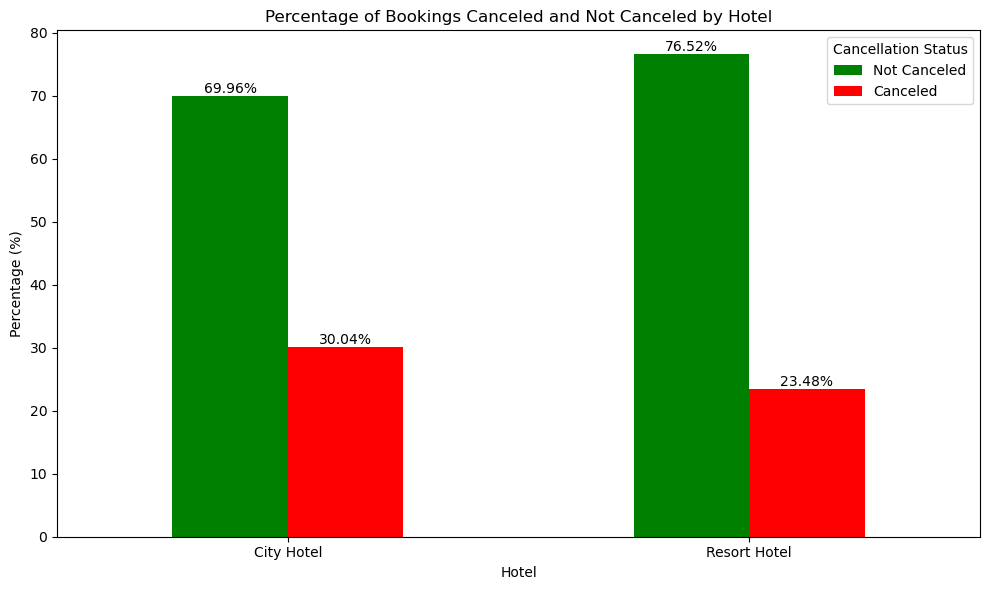

In [60]:
cancellation_counts = hotels.groupby(['hotel', 'is_canceled']).size().unstack(fill_value=0)
total_bookings = hotels.groupby('hotel').size()
cancellation_percentages = cancellation_counts.div(total_bookings, axis=0) * 100

custom_palette = {"Yes": "red", "No": "green"}
ax = cancellation_percentages.plot(kind='bar', stacked=False, figsize=(10, 6), color=[custom_palette["No"], custom_palette["Yes"]])

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')

plt.title('Percentage of Bookings Canceled and Not Canceled by Hotel')
plt.xlabel('Hotel')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)

legend_labels = ['Not Canceled', 'Canceled']
legend = plt.legend(title='Cancellation Status', labels=legend_labels)


plt.tight_layout()

plt.show()

## Bookings and cancellations by month

Monthly cancellations mirrors what we saw in total bookings earlier. The city hotel has overall seen an increase in cancellations, whereas the resort hotel has been more stable. There appears to be some seasonality for both hotels, with an increase in cancellations seen during spring and summer and a decrease in the winter months. However, more data over a period of several years would be needed to confirm this trend.

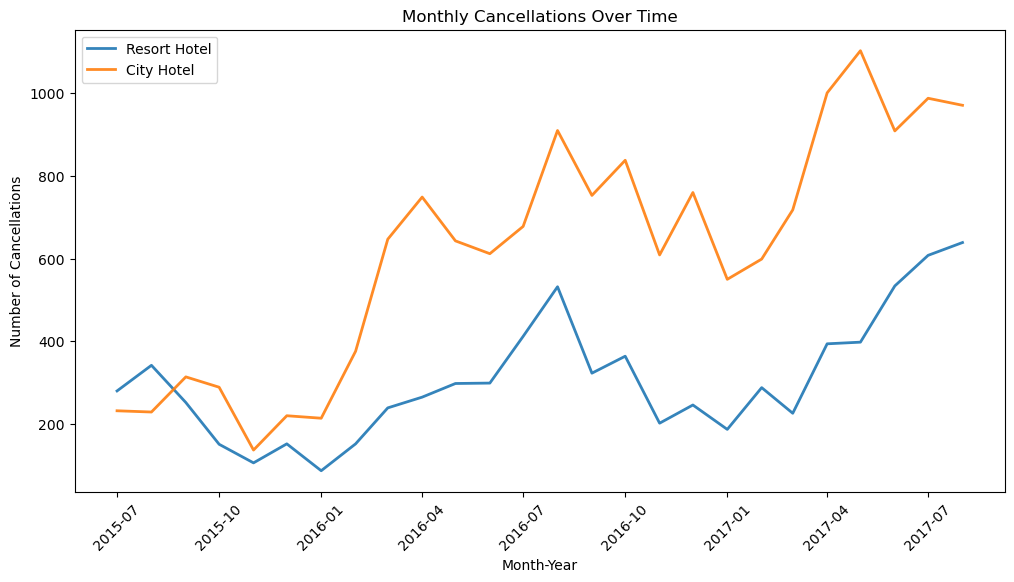

In [61]:
monthly_cancellation_counts = hotels[hotels['is_canceled'] == 1].groupby(['hotel', 'month_year']).size().reset_index(name='cancellation_count')

monthly_cancellation_counts_pivot = monthly_cancellation_counts.pivot(index='month_year', columns='hotel', values='cancellation_count').fillna(0)

plt.figure(figsize=(12, 6))
ax = plt.gca()

ax.plot(monthly_cancellation_counts_pivot.index, monthly_cancellation_counts_pivot['Resort Hotel'], marker='', linewidth=2, alpha=0.9, label='Resort Hotel')
ax.plot(monthly_cancellation_counts_pivot.index, monthly_cancellation_counts_pivot['City Hotel'], marker='', linewidth=2, alpha=0.9, label='City Hotel')

plt.title("Monthly Cancellations Over Time")
plt.xlabel("Month-Year")
plt.ylabel("Number of Cancellations")
plt.legend()
plt.xticks(rotation=45)

plt.show()

## Cancellation Rate

We can see higher cancellation rates in the summer and lower rates in the winter, especially for the resort hotel. This suggests we could be more comfortable overbooking rooms during the summer months, knowing more customers are likely to cancel their reservations. Furthermore, it is concerning that the resort hotel seems to be catching up with and potentially overtaking the city hotel in cancellation rate. Again, more data over a longer period would be preferable to confirm this trend. 


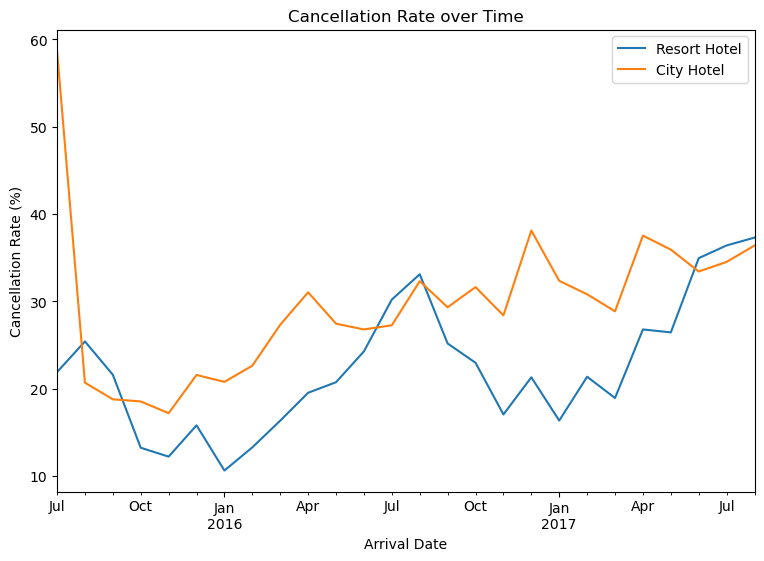

In [62]:
resort_monthly_cancel_count = resort.groupby(pd.Grouper(key='arrival_date', freq='M')).is_canceled.sum()
resort_monthly_total_count = resort.groupby(pd.Grouper(key='arrival_date', freq='M')).size()
resort_monthly_cancel_rate = resort_monthly_cancel_count * 100 / resort_monthly_total_count 
city_monthly_cancel_count = city.groupby(pd.Grouper(key='arrival_date', freq='M')).is_canceled.sum()
city_monthly_total_count = city.groupby(pd.Grouper(key='arrival_date', freq='M')).size()
city_monthly_cancel_rate = city_monthly_cancel_count * 100 / city_monthly_total_count 

resort_monthly_cancel_rate.plot(kind='line', label='Resort Hotel')
city_monthly_cancel_rate.plot(kind='line', label='City Hotel')
plt.legend()
plt.ylabel('Cancellation Rate (%)')
plt.xlabel('Arrival Date')
plt.title('Cancellation Rate over Time')
plt.show()


## Effect of prices on cancellations

Canceled bookings tend to be more expensive than non-canceled bookings, as seen in their distributions. This suggests there might be a sweet price range (approximately under 200 euro for the resort and under 300 euro for the city hotel) where customers are more likely to keep their reservation. We can utilize this to adjust pricing strategy to reduce cancellations where possible.

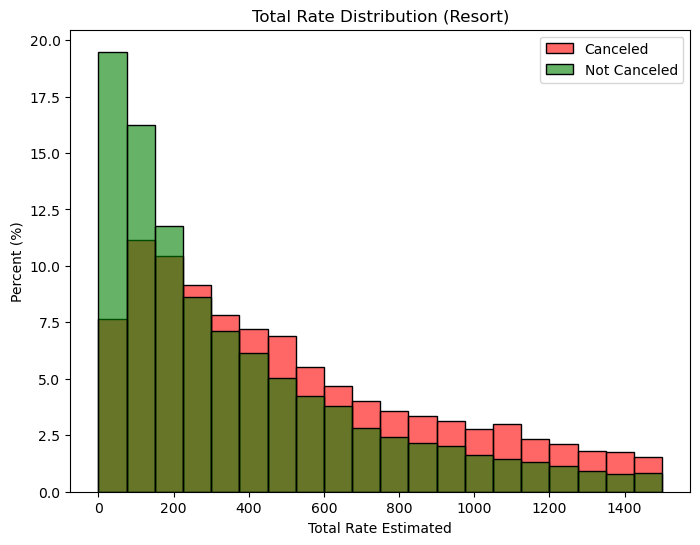

In [63]:
resort_canceled_data = resort[resort['is_canceled'] == True]
resort_not_canceled_data = resort[resort['is_canceled'] == False]
city_canceled_data = city[city['is_canceled'] == True]
city_not_canceled_data = city[city['is_canceled'] == False]

plt.figure(figsize=(8, 6))
sns.histplot(data=resort_canceled_data, x='total_rate_estimated', binwidth=75, binrange=(0,1500), color='red', label='Canceled', alpha=0.6, stat='percent')
sns.histplot(data=resort_not_canceled_data, x='total_rate_estimated', binwidth=75, binrange=(0,1500), color='green', label='Not Canceled', alpha=0.6, stat='percent')

plt.title('Total Rate Distribution (Resort)')
plt.xlabel('Total Rate Estimated')
plt.ylabel('Percent (%)')

plt.legend()

plt.show()

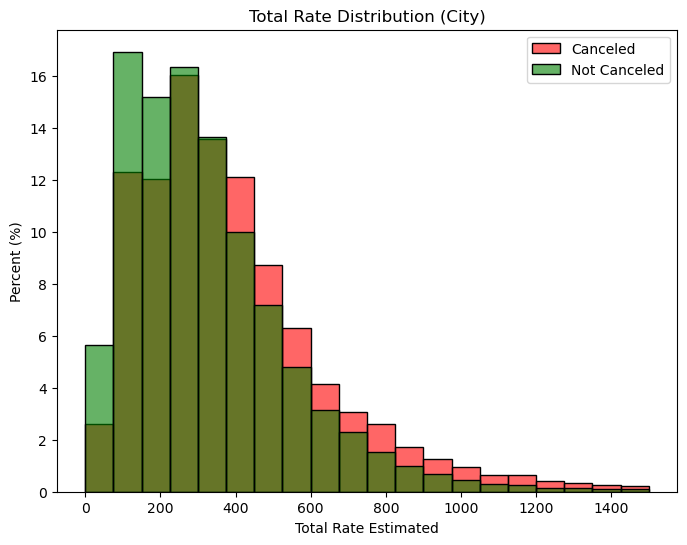

In [64]:
plt.figure(figsize=(8, 6))
sns.histplot(data=city_canceled_data, x='total_rate_estimated', binwidth=75, binrange=(0,1500), color='red', label='Canceled', alpha=0.6, stat='percent')
sns.histplot(data=city_not_canceled_data, x='total_rate_estimated', binwidth=75, binrange=(0,1500), color='green', label='Not Canceled', alpha=0.6, stat='percent')

plt.title('Total Rate Distribution (City)')
plt.xlabel('Total Rate Estimated')
plt.ylabel('Percent (%)')

plt.legend()

plt.show()

## Number of guests and cancellation status

Generally, larger parties are more likely to cancel their reservations at both hotels. This is especially the case for groups of 4 or more. We may wish to market more heavily toward single travelers, who are significantly less likely to cancel at both hotels.

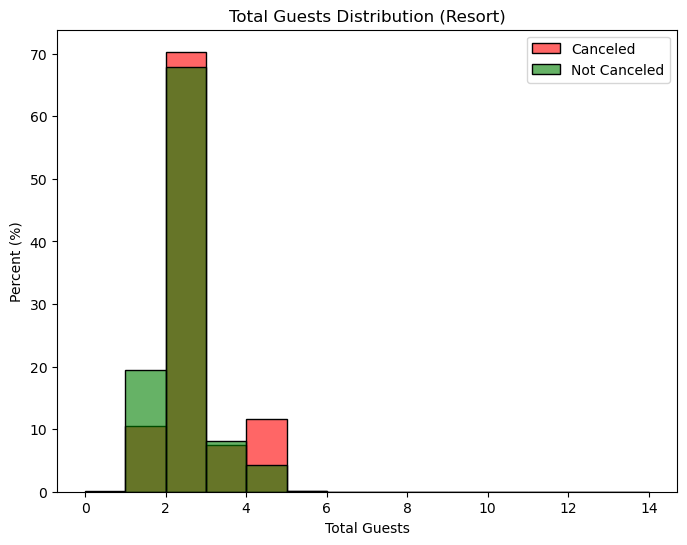

In [65]:
plt.figure(figsize=(8, 6))
sns.histplot(data=resort_canceled_data, x='total_guests', binwidth=1, binrange=(0,14), color='red', label='Canceled', alpha=0.6, stat='percent')
sns.histplot(data=resort_not_canceled_data, x='total_guests', binwidth=1, binrange=(0,14), color='green', label='Not Canceled', alpha=0.6, stat='percent')

plt.title('Total Guests Distribution (Resort)')
plt.xlabel('Total Guests')
plt.ylabel('Percent (%)')

plt.legend()

plt.show()

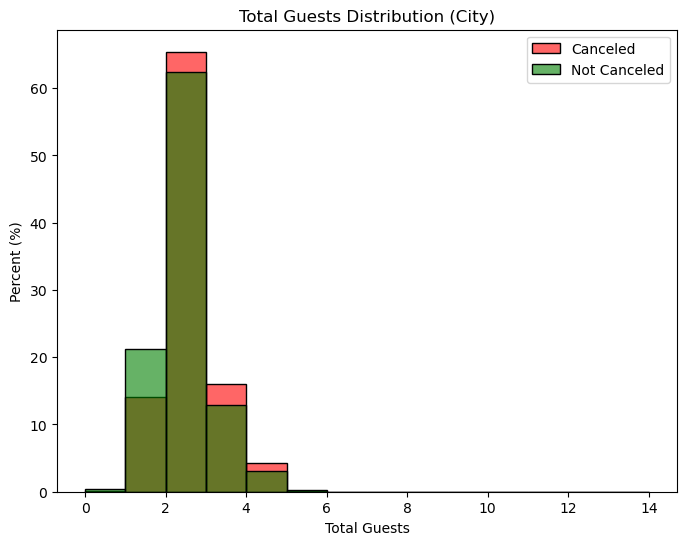

In [66]:
plt.figure(figsize=(8, 6))
sns.histplot(data=city_canceled_data, x='total_guests', binwidth=1, binrange=(0,14), color='red', label='Canceled', alpha=0.6, stat='percent')
sns.histplot(data=city_not_canceled_data, x='total_guests', binwidth=1, binrange=(0,14), color='green', label='Not Canceled', alpha=0.6, stat='percent')

plt.title('Total Guests Distribution (City)')
plt.xlabel('Total Guests')
plt.ylabel('Percent (%)')

plt.legend()

plt.show()

## Country of origin vs cancellations

Let's take a look at different countries of origin and their cancellation rates. To focus our efforts, we will look at countries with more than 1000 bookings.

In [88]:
cancel_by_country = hotels.groupby('country').is_canceled.sum().reset_index(name='cancellations')
bookings_by_country = hotels.groupby('country').size().reset_index(name='bookings')

countries = cancel_by_country.merge(bookings_by_country, on='country')
countries['cancel_rate'] = 100.0 * countries.cancellations / countries.bookings
countries_sorted = countries.sort_values(by='bookings', ascending=False)


Portugal has the highest number of raw cancellations (4906) as well as highest cancellation rate (35%). This is likely due to the fact that the hotel is located in Portugal, and domestic travelers are more likely to change their plans as travel is more flexible.

In [89]:
data = countries_sorted[countries_sorted.bookings > 1000].set_index('country')
data

,cancellations,bookings,cancel_rate
country,,,
PRT,9791,27453,35.664590
GBR,1985,10433,19.026167
FRA,1733,8837,19.610728
ESP,1862,7252,25.675676
DEU,1053,5387,19.547058
ITA,1075,3066,35.061970
IRL,668,3016,22.148541
BEL,411,2081,19.750120
BRA,727,1995,36.441103


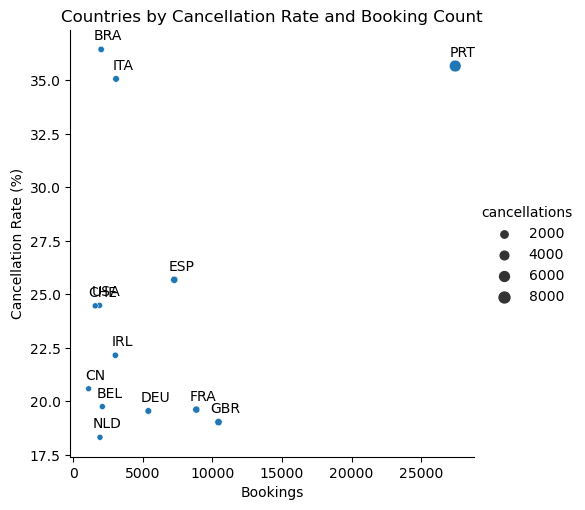

In [99]:
sns.relplot(data=data, x='bookings', y='cancel_rate', size='cancellations')
ax = plt.gca()
for index, row in data.iterrows():
    ax.text(row['bookings'] + 500, row['cancel_rate'] + 0.3, index, fontsize=10, ha='center', va='bottom')
plt.ylabel('Cancellation Rate (%)')
plt.xlabel('Bookings')
plt.title('Countries by Cancellation Rate and Booking Count')
plt.show()

Dropping Portugal from our dataset allows us to see the other countries better in our scatterplot. We may want to focus our efforts on attracting British and French customers, who are responsbile for many bookings and are unlikely to cancel. 

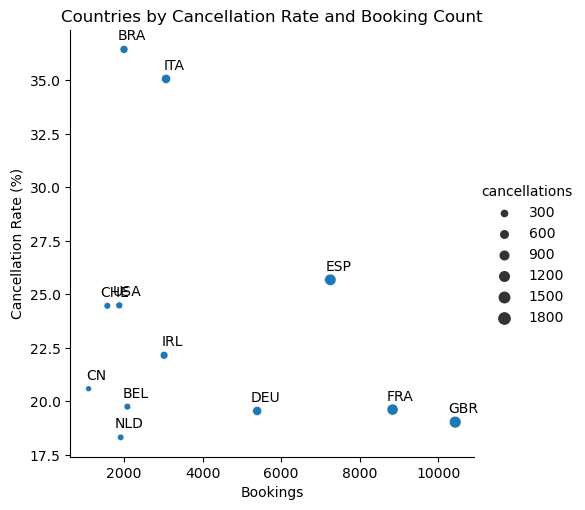

In [98]:
data2 = data.drop('PRT')
data2
sns.relplot(data=data2, x='bookings', y='cancel_rate', size='cancellations')
ax = plt.gca()
for index, row in data2.iterrows():
    ax.text(row['bookings'] + 200, row['cancel_rate'] + 0.3, index, fontsize=10, ha='center', va='bottom')
plt.ylabel('Cancellation Rate (%)')
plt.xlabel('Bookings')
plt.title('Countries by Cancellation Rate and Booking Count')
plt.show()



## Percent of previous bookings canceled and cancellation rate

Customers with a higher percentage of previous bookings canceled are more likely to cancel. Those who had over 90% cancellation rate of previous bookings were overwhelmingly more likely to cancel than keep their reservations.

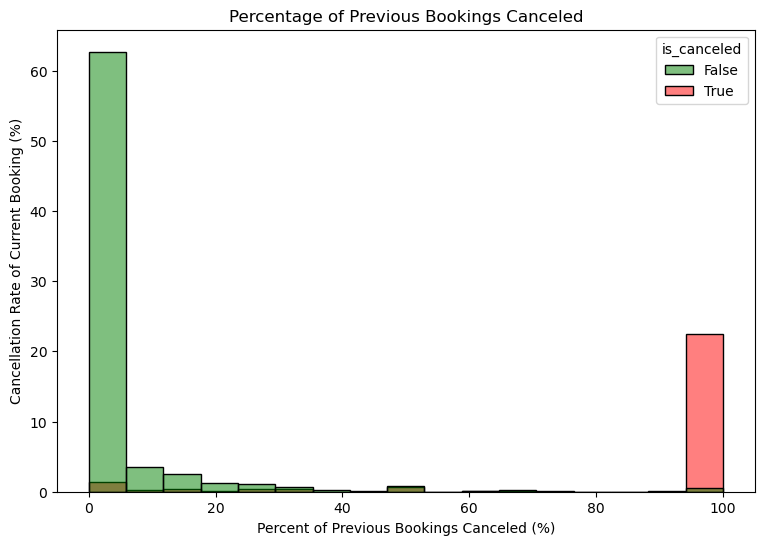

In [87]:

custom_palette = {True: "red", False: "green"}
sns.histplot(data=hotels, x='pct_previous_bookings_canceled', hue='is_canceled', stat='percent', palette=custom_palette)
plt.title('Percentage of Previous Bookings Canceled')
plt.xlabel('Percent of Previous Bookings Canceled (%)')
plt.ylabel('Cancellation Rate of Current Booking (%)')
plt.show()


## Parking spaces and cancellations

Of reservations with 0 required car parking spaces, nearly half were canceled. However, all bookings with any number of parking spaces greater than 0 were kept. We may want to entice guests who are driving to the hotel by offering discounted parking.

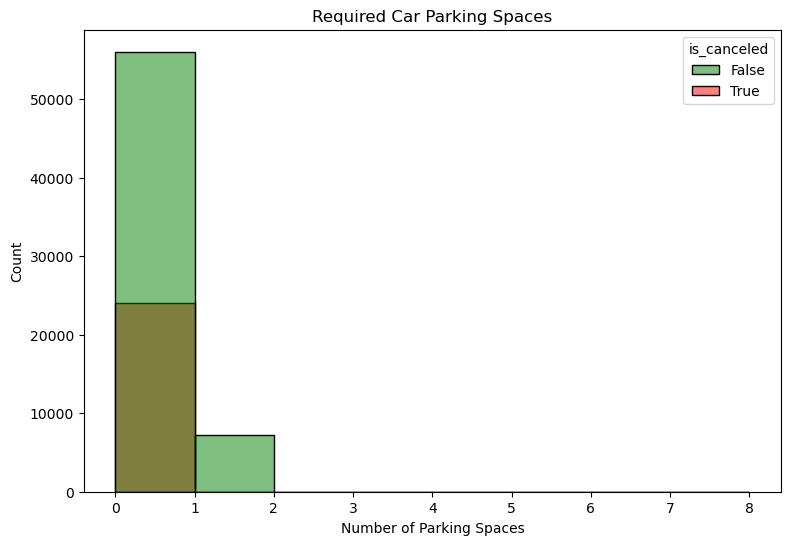

In [72]:
sns.histplot(data=hotels, x='required_car_parking_spaces', binwidth=1, hue='is_canceled', palette=custom_palette)
plt.title('Required Car Parking Spaces')
plt.xlabel('Number of Parking Spaces')
plt.show()

## Developing a regression model to predict cancellation
Having explored the data and gotten a sense of each hotel's overall booking patterns as well as how different variables are related to cancellation, we will develop a regression model to help us potentially predict cancellations.



The variable most strongly correlated to cancellations is percentage of previous bookings canceled (r=0.90). Other variables with a slight association with cancellations were lead time (r = 0.19) and required car parking spaces (r = -0.18).

C:\Users\shawn\AppData\Local\Temp\ipykernel_14468\2715632689.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cancel_corr = hotels.corr().is_canceled.sort_values(ascending=False).iloc[2:].round(3)


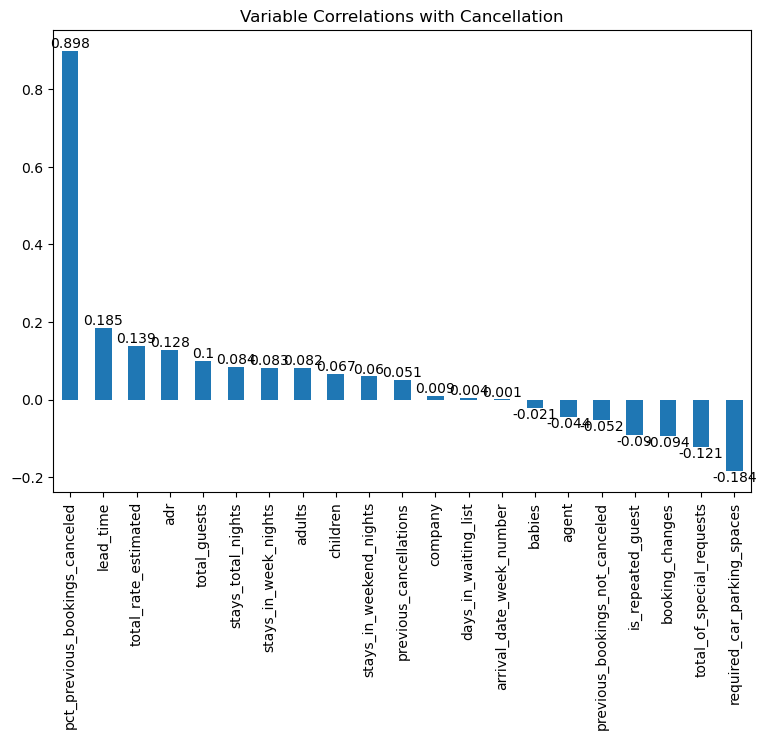

In [100]:
cancel_corr = hotels.corr().is_canceled.sort_values(ascending=False).iloc[2:].round(3)
ax = cancel_corr.plot(kind='bar')
ax.bar_label(ax.containers[0])
plt.title('Variable Correlations with Cancellation')
plt.show()

In [108]:
market_segment = pd.get_dummies(hotels['market_segment'])
customer_type = pd.get_dummies(hotels['customer_type'])
distribution_channel = pd.get_dummies(hotels['distribution_channel'], prefix='dist')
meal = pd.get_dummies(hotels['meal'], prefix='meal')
reserved_room_type = pd.get_dummies(hotels['reserved_room_type'], prefix='reserved')
assigned_room_type = pd.get_dummies(hotels['assigned_room_type'], prefix='assigned')
deposit_type = pd.get_dummies(hotels['deposit_type'])
arrival_date_month = pd.get_dummies(hotels['arrival_date_month'])
arrival_date_year = pd.get_dummies(hotels['arrival_date_year'])
arrival_date_day_of_month = pd.get_dummies(hotels['arrival_date_day_of_month'])
df = pd.concat([hotels, market_segment, customer_type, distribution_channel,
               meal, reserved_room_type, assigned_room_type, deposit_type,
               arrival_date_month, arrival_date_year, arrival_date_day_of_month], axis=1)

In [109]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

X = df[['pct_previous_bookings_canceled', 'lead_time',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list',
       'required_car_parking_spaces', 'total_of_special_requests', 
        'stays_total_nights', 'total_guests', 'total_rate_estimated',
        'April', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September', '2015',
       '2016', '2017']].fillna(0)

y = df['is_canceled_int']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)





c:\Users\shawn\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [110]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)


Text(0.5, 533.5555555555555, 'Predicted label')

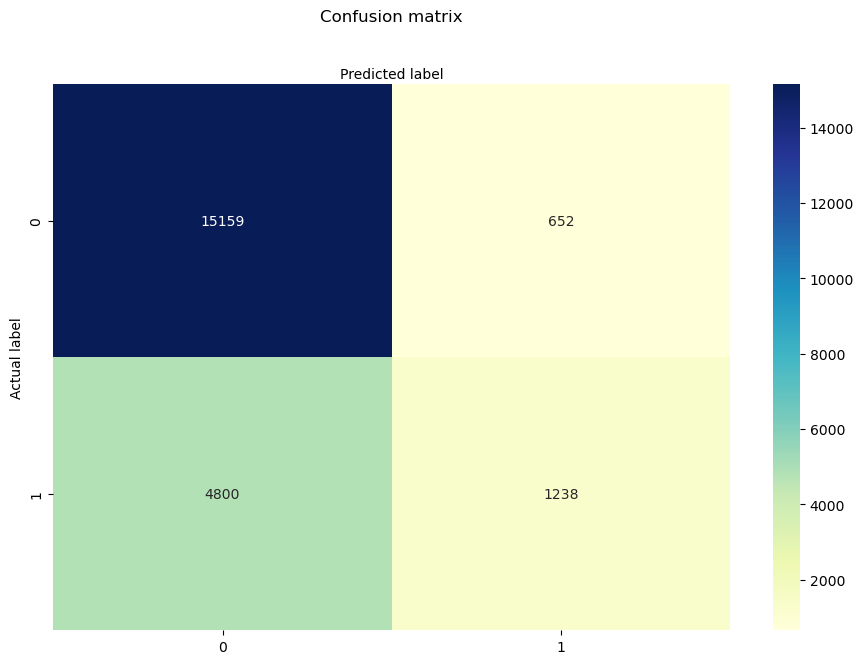

In [114]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


Our model has good performance predicting non-canceled bookings but struggles more with canceled bookings. Of the bookings it predicts as being canceled, 66% end up being canceled. Of all canceled bookings, it was able to correctly predict 21% of the booking outcomes correctly. Overall, the model seems likely to overpredict bookings as being kept rather than canceled.

In [112]:
from sklearn.metrics import classification_report
target_names = ['Not Canceled', 'Canceled']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

Not Canceled       0.76      0.96      0.85     15811
    Canceled       0.66      0.21      0.31      6038

    accuracy                           0.75     21849
   macro avg       0.71      0.58      0.58     21849
weighted avg       0.73      0.75      0.70     21849



To best understand which variables are most important in our regression model, we extracted and plotted the absolute values of the 8 most important features. Required car parking spaces had the highest feature importance in our model.

<Axes: ylabel='Feature'>

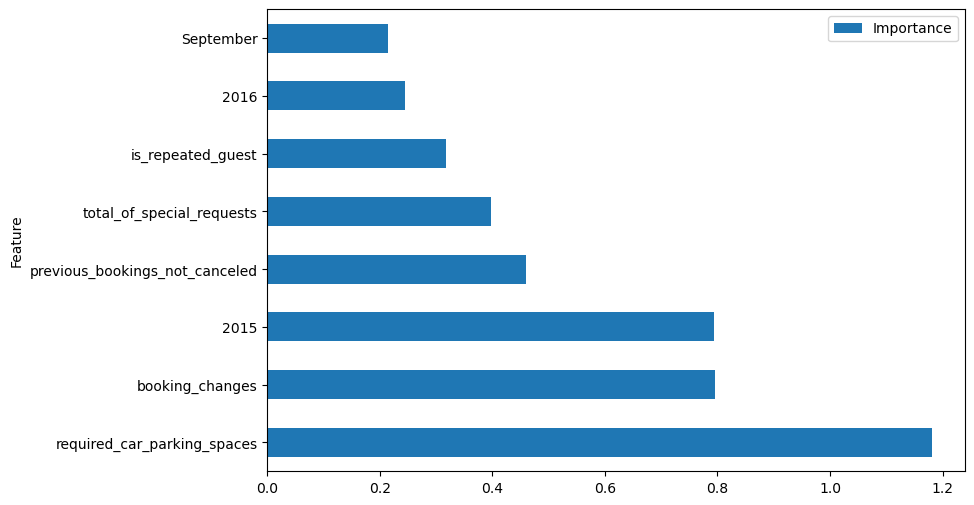

In [113]:
coefficients = logreg.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance.iloc[:8].plot(x='Feature', y='Importance', kind='barh')

## Insights

* The city hotel has a higher number of bookings than the resort hotel. This has been increasing over time, while the resort hotel bookings have remained stable. There appears to be some seasonality in bookings, with higher numbers in the summer and lower numbers in the winter. This seasonality is also seen when examining cancellation rates.

* Guests at the resort hotel tend to stay for longer, whereas the city hotel has more short-term (2-3 nights) stays.

* While the most common guest party size is 2 at both hotels, the resort hotel sees a larger number of party sizes of 4+. Larger parties are also more likely to cancel.

* The resort hotel has a significantly greater number of guests making their reservations on short notice, within a week of their check-in.

* Higher prices are associated with more cancellations.

* The UK and France are countries with high bookings and low cancellation rates. We should market more heavily to these countries.

* Reservations that had a parking space didn't cancel. In fact, in our logistic model, this was the most important feature, suggesting we should aim to entice customers who are driving by offering discounted parking spaces or expanding our parking infrastructure if necessary.